In [2]:
%pip install gym

  Using cached gym-0.26.2-py3-none-any.whl
  Using cached gym_notices-0.0.8-py3-none-any.whl (3.0 kB)
  Using cached cloudpickle-3.1.0-py3-none-any.whl (22 kB)

[notice] A new release of pip is available: 23.0.1 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [3]:
# 코드 12-1 라이브러리 호출
import gym
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import (
    namedtuple,
)  # 튜플에 담긴 요소들의 인덱스와 값으로 모두 접근 가능
from itertools import count  # 무한 루프 사용을 위한 라이브러리
from PIL import Image  # 이미지 처리를 위한 라이브러리

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T

env = gym.make("CartPole-v1").unwrapped  # cartpole이라는 강화 학습 환경을 불러옵니다.
plt.ion()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
# 코드 12-2 한글 깨짐 방지
from matplotlib import font_manager

# font_fname = "C:/Windows/Fonts/malgun.ttf"
font_fname = "/mnt/c/Windows/Fonts/malgun.ttf"
font_family = font_manager.FontProperties(fname=font_fname).get_name()
plt.rcParams["font.family"] = font_family

In [5]:
# 코드 12-3 리플레이 메모리
Transition = namedtuple("Transition", ("state", "action", "next_state", "reward"))  # ①


class ReplayMemory(object):  # ②
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, *args):
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [6]:
# 코드 12-4 DQN 모델 네트워크
class DQN(nn.Module):
    def __init__(self, h, w, outputs):
        super(DQN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=5, stride=2)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, stride=2)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 32, kernel_size=5, stride=2)
        self.bn3 = nn.BatchNorm2d(32)

        def conv2d_size_out(size, kernel_size=5, stride=2):
            return (size - (kernel_size - 1) - 1) // stride + 1

        convw = conv2d_size_out(conv2d_size_out(conv2d_size_out(w)))
        convh = conv2d_size_out(conv2d_size_out(conv2d_size_out(h)))
        linear_input_size = convw * convh * 32  # ①
        self.head = nn.Linear(linear_input_size, outputs)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        return self.head(
            x.view(x.size(0), -1)
        )  # 함수의 반환값은 [[left0exp,right0exp]...]와 같으며 다음 행동을 결정하기 위해 사용

In [7]:
%pip install pyglet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 945.1/945.1 kB 15.7 MB/s eta 0:00:00a 0:00:01

[notice] A new release of pip is available: 23.0.1 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [19]:
# 코드 12-5 이미지 추출 및 처리
import pyglet
from PIL import Image

resize = T.Compose(
    [T.ToPILImage(), T.Resize(40, interpolation=Image.BICUBIC), T.ToTensor()]
)  # 이미지 크기 및 텐서 변환


def get_cart_location(screen_width):  # 카트의 위치 정보 가져오기
    world_width = env.x_threshold * 2
    scale = screen_width / world_width
    return int(env.state[0] * scale + screen_width / 2.0)  # 카트의 중간(중앙) 위치


def get_screen():  # ①
    screen = env.render(mode="rgb_array").transpose((2, 0, 1))  # ②
    _, screen_height, screen_width = screen.shape
    screen = screen[:, int(screen_height * 0.4) : int(screen_height * 0.8)]
    view_width = int(screen_width * 0.6)
    cart_location = get_cart_location(screen_width)

    if (
        cart_location < view_width // 2
    ):  # 카트는 출력 화면의 아래쪽 중앙에 존재하므로 화면의 위쪽과 아래쪽을 제거
        slice_range = slice(view_width)  # ③
    elif cart_location > (screen_width - view_width // 2):
        slice_range = slice(-view_width, None)
    else:
        slice_range = slice(
            cart_location - view_width // 2, cart_location + view_width // 2
        )
    screen = screen[
        :, :, slice_range
    ]  # 카트가 화면의 중앙에 위치하도록 가장자리를 제거
    screen = np.ascontiguousarray(screen, dtype=np.float32) / 255  # ④
    screen = torch.from_numpy(screen)  # 텐서로 변환
    return (
        resize(screen).unsqueeze(0).to(device)
    )  # 출력 크기 조정 및 배치 차원 추가하여 데이터는 (배치, 채널, 높이, 너비)의 형태를 갖습니다.


env.reset()  # 환경을 초기화
plt.figure()
plt.imshow(
    get_screen().cpu().squeeze(0).permute(1, 2, 0).numpy(), interpolation="none"
)  # permute 함수는 transpose 함수처럼 차원을 바꾸어서 표현할 때 사용
plt.title("화면 예시")
plt.show()

/home/halozhan/딥러닝 파이토치 교과서/.venv/lib/python3.8/site-packages/torchvision/transforms/transforms.py:280: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  warnings.warn(


TypeError: render() got an unexpected keyword argument 'mode'

<Figure size 640x480 with 0 Axes>

In [23]:
%pip install gym[classic_control]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 26.1 MB/s eta 0:00:0000:0100:01

[notice] A new release of pip is available: 23.0.1 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


/home/halozhan/딥러닝 파이토치 교과서/.venv/lib/python3.8/site-packages/torchvision/transforms/transforms.py:280: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  warnings.warn(
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
/home/halozhan/딥러닝 파이토치 교과서/.venv/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 54868 (\N{HANGUL SYLLABLE HWA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/halozhan/딥러닝 파이토치 교과서/.venv/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 47732 (\N{HANGUL SYLLABLE MYEON}) missing from current font.
  fig.canvas.print_figur

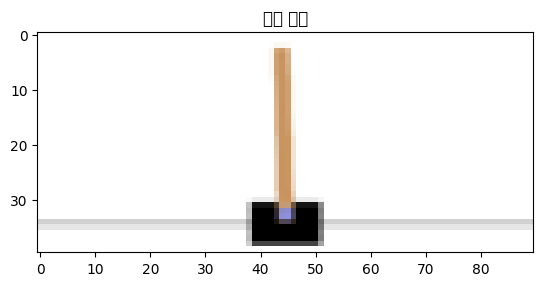

In [24]:
import gym  # gym 라이브러리 추가
import numpy as np
import torch
import torchvision.transforms as T
from PIL import Image
import matplotlib.pyplot as plt

# GPU가 사용 가능하다면, GPU를 사용하도록 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 환경 초기화
env = gym.make('CartPole-v1', render_mode='rgb_array')  # render_mode 설정

resize = T.Compose(
    [T.ToPILImage(), T.Resize(40, interpolation=Image.BICUBIC), T.ToTensor()]
)

def get_cart_location(screen_width):
    world_width = env.x_threshold * 2
    scale = screen_width / world_width
    return int(env.state[0] * scale + screen_width / 2.0)

def get_screen():
    screen = env.render().transpose((2, 0, 1))  # render_mode로 초기화했으므로 인자 필요 없음
    _, screen_height, screen_width = screen.shape
    screen = screen[:, int(screen_height * 0.4):int(screen_height * 0.8)]
    view_width = int(screen_width * 0.6)
    cart_location = get_cart_location(screen_width)

    if cart_location < view_width // 2:
        slice_range = slice(view_width)
    elif cart_location > (screen_width - view_width // 2):
        slice_range = slice(-view_width, None)
    else:
        slice_range = slice(
            cart_location - view_width // 2, cart_location + view_width // 2
        )
    screen = screen[:, :, slice_range]
    screen = np.ascontiguousarray(screen, dtype=np.float32) / 255
    screen = torch.from_numpy(screen)
    return resize(screen).unsqueeze(0).to(device)

env.reset()
plt.figure()
plt.imshow(
    get_screen().cpu().squeeze(0).permute(1, 2, 0).numpy(), interpolation="none"
)
plt.title("화면 예시")
plt.show()


In [25]:
# 코드 12-6 모델 객체화 및 손실 함수 정의
BATCH_SIZE = 128
GAMMA = 0.999
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 200
TARGET_UPDATE = 10
init_screen = get_screen() # ①
_, _, screen_height, screen_width = init_screen.shape
n_actions = env.action_space.n # gym에서 행동(action)에 대한 횟수를 가져옵니다.

policy_net = DQN(screen_height, screen_width, n_actions).to(device)
target_net = DQN(screen_height, screen_width, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict()) # ②
target_net.eval()

optimizer = optim.RMSprop(policy_net.parameters())
memory = ReplayMemory(10000)

steps_done = 0

def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            return policy_net(state).max(1)[1].view(1, 1) # max(1)은 각 행의 가장 큰 열 값을 반환
    else:
        return torch.tensor([[random.randrange(n_actions)]], device=device,  dtype=torch.long)

episode_durations = []

In [26]:
# 코드 12-7 모델에서 사용할 옵티마이저 정의
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return

    transitions = memory.sample(BATCH_SIZE)
    batch = Transition(*zip(*transitions))  # ①
    non_final_mask = torch.tensor(
        tuple(map(lambda s: s is not None, batch.next_state)),
        device=device,
        dtype=torch.bool,
    )  # ②
    non_final_next_states = torch.cat(
        [s for s in batch.next_state if s is not None]
    )  # torch.cat을 이용하여 s 값들을 이어 붙입니다.

    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    state_action_values = policy_net(state_batch).gather(
        1, action_batch
    )  # Q(st,at)를 계산
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    next_state_values[non_final_mask] = (
        target_net(non_final_next_states).max(1)[0].detach()
    )  # ③

    expected_state_action_values = (
        next_state_values * GAMMA
    ) + reward_batch  # V(st+1)을 계산

    loss = F.smooth_l1_loss(
        state_action_values, expected_state_action_values.unsqueeze(1)
    )  # ④
    optimizer.zero_grad()
    loss.backward()

    for param in policy_net.parameters():
        param.grad.data.clamp_(-1, 1)
    optimizer.step()

In [28]:
# 코드 12-8 모델 학습
num_episodes = 50

for i_episode in range(num_episodes):
    env.reset()  # 환경과 상태 초기화
    last_screen = get_screen()
    current_screen = get_screen()
    state = current_screen - last_screen

    for t in count():
        action = select_action(state)  # 행동 선택 및 실행
        _, reward, done, _, _ = env.step(
            action.item()
        )  # 선택한 행동(action)을 환경으로 보냅니다.
        reward = torch.tensor([reward], device=device)

        last_screen = current_screen
        current_screen = get_screen()

        if not done:  # 새로운 상태 관찰(observe)
            next_state = current_screen - last_screen
        else:
            next_state = None

        memory.push(
            state, action, next_state, reward
        )  # 상태 전이(state transition)를 메모리에 저장
        state = next_state  # 다음 상태로 이동

        optimize_model()  # 타깃(큐) 네트워크에 대해 최적화 진행
        if done:
            episode_durations.append(t + 1)
            break

    if i_episode % TARGET_UPDATE == 0:
        target_net.load_state_dict(
            policy_net.state_dict()
        )  # 큐 네트워크의 모든 가중치와 바이어스를 복사하여 타깃(큐) 네트워크를 업데이트합니다.

print("종료")
env.render()  # 화면을 출력
env.close()  # 화면을 종료
plt.show()

종료
